In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
rm: cannot remove 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d melekelloumi/fer13-even-more-cleaned-dataset

 80% 33.0M/41.1M [00:00<00:00, 71.3MB/s]
100% 41.1M/41.1M [00:00<00:00, 74.8MB/s]


In [ ]:
! mkdir /content/fer13-even-more-cleaned-dataset
! cp /content/fer13-even-more-cleaned-dataset.zip /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset.zip
! unzip /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset -d /content/fer13-even-more-cleaned-dataset/
! rm /content/fer13-even-more-cleaned-dataset.zip
! rm /content/fer13-even-more-cleaned-dataset/fer13-even-more-cleaned-dataset.zip

In [ ]:
! pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 9.0 MB/s 
     |████████████████████████████████| 381 kB 54.9 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [1]:
import os

#INPUT_PATH="/content/FER_cleaned/"
INPUT_PATH="/content/fer13-even-more-cleaned-dataset/"
for expression in os.listdir(INPUT_PATH):
    print(str(len(os.listdir(INPUT_PATH + expression))) + " " + expression + " images")

6834 happy images
380 disgust images
3036 surprise images
2535 fear images
4295 neutral images
4685 sad images
2832 angry images


In [2]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model
from livelossplot import PlotLossesKerasTF

from keras.utils import np_utils

In [3]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

happy has 6834 number of images
disgust has 380 number of images
surprise has 3036 number of images
fear has 2535 number of images
neutral has 4295 number of images
sad has 4685 number of images
angry has 2832 number of images

total images are 24597


In [4]:
TOP_EMOTIONS = ["happy","surprise","fear", "neutral","sad", "angry"]
total_images -= 380
total_images

24217

In [5]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all happy images to numpy arrays
loaded all surprise images to numpy arrays
loaded all fear images to numpy arrays
loaded all neutral images to numpy arrays
loaded all sad images to numpy arrays
loaded all angry images to numpy arrays


((24217, 48, 48, 3), array([0., 0., 0., ..., 5., 5., 5.]))

In [6]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(24217, 6)

In [7]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((21795, 48, 48, 3), (2422, 48, 48, 3), (21795, 6), (2422, 6))

In [8]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
img_width,img_height,img_depth,num_classes

(48, 48, 3, 6)

In [9]:
mobile_net = MobileNet(
    input_shape = (img_width,img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)


x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [10]:
for layer in model.layers[:15]:
    layer.trainable = False

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
checkpointer = ModelCheckpoint(filepath = "weights-final-4.h5", verbose = 1, save_best_only=True)
callbacks = [
             PlotLossesKerasTF(),
    early_stopping,
    lr_scheduler,
    checkpointer
]
batch_size = 16
epochs = 18

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.0003),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

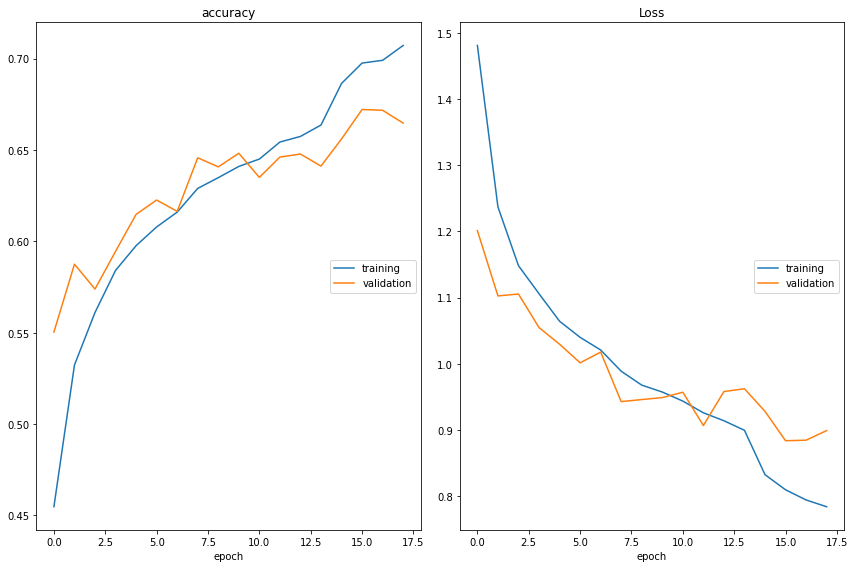

accuracy
	training         	 (min:    0.455, max:    0.707, cur:    0.707)
	validation       	 (min:    0.550, max:    0.672, cur:    0.665)
Loss
	training         	 (min:    0.784, max:    1.481, cur:    0.784)
	validation       	 (min:    0.884, max:    1.201, cur:    0.899)

Epoch 18: val_loss did not improve from 0.88375
1362/1362 [==============================] - 219s 161ms/step - loss: 0.7840 - accuracy: 0.7072 - val_loss: 0.8991 - val_accuracy: 0.6647 - lr: 7.5000e-05


In [12]:
#adam 0.0003 batch=16 NEW FER
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

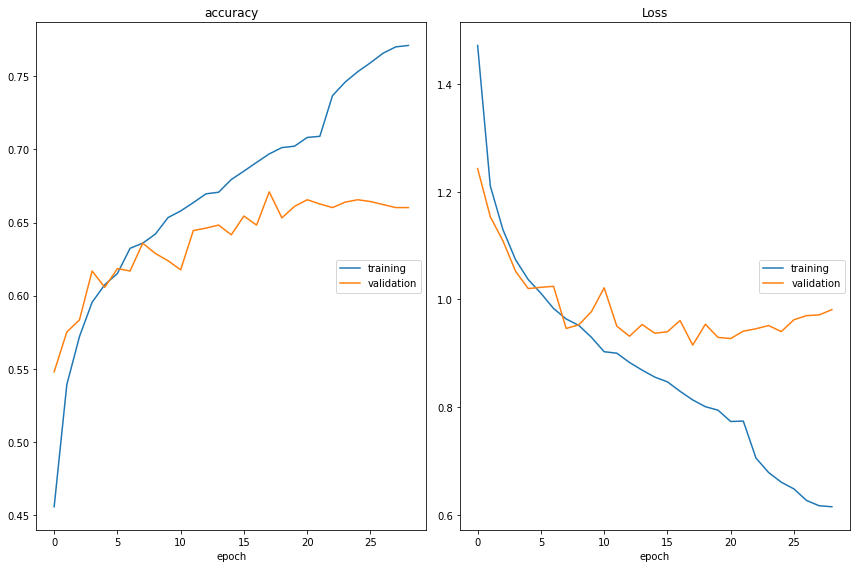

accuracy
	training         	 (min:    0.456, max:    0.771, cur:    0.771)
	validation       	 (min:    0.548, max:    0.671, cur:    0.660)
Loss
	training         	 (min:    0.615, max:    1.472, cur:    0.615)
	validation       	 (min:    0.915, max:    1.243, cur:    0.981)
Restoring model weights from the end of the best epoch: 18.

Epoch 29: val_loss did not improve from 0.91510
681/681 [==============================] - 219s 321ms/step - loss: 0.6148 - accuracy: 0.7710 - val_loss: 0.9810 - val_accuracy: 0.6602 - lr: 1.8750e-05
Epoch 29: early stopping


In [ ]:
#adam 0.0003 batch=32 NEW FER
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

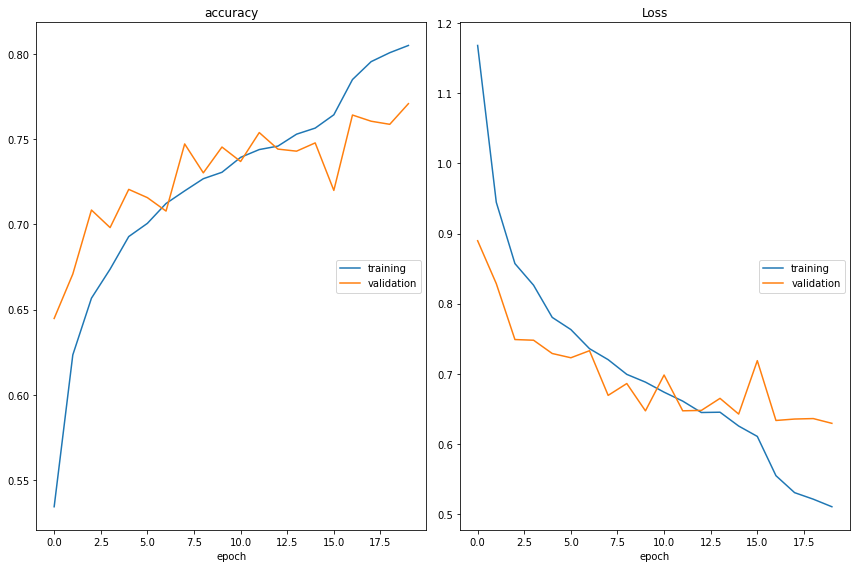

accuracy
	training         	 (min:    0.534, max:    0.805, cur:    0.805)
	validation       	 (min:    0.645, max:    0.771, cur:    0.771)
Loss
	training         	 (min:    0.510, max:    1.168, cur:    0.510)
	validation       	 (min:    0.629, max:    0.890, cur:    0.629)

Epoch 20: val_loss improved from 0.63348 to 0.62940, saving model to FacialExpression_weights2.h5
927/927 [==============================] - 155s 167ms/step - loss: 0.5105 - accuracy: 0.8051 - val_loss: 0.6294 - val_accuracy: 0.7709 - lr: 7.5000e-05


In [ ]:
#adam 0.0003 batch=16
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

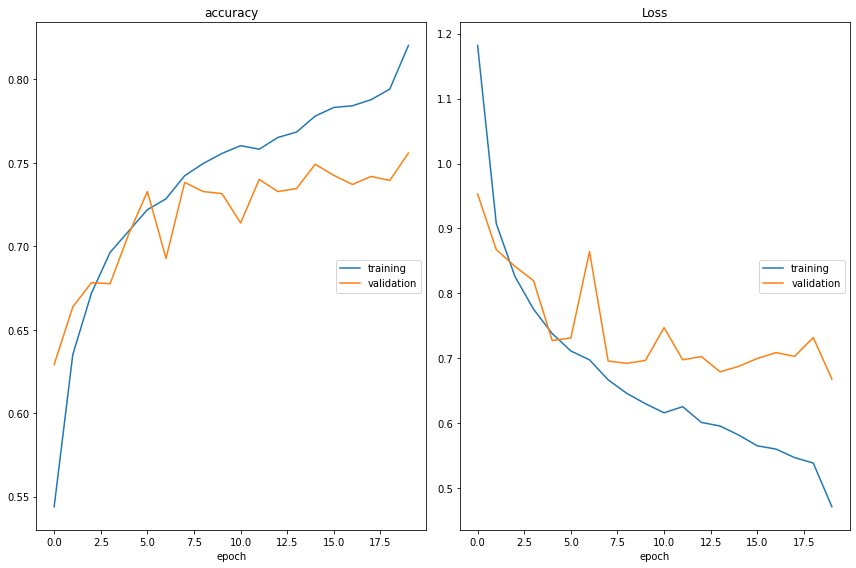

accuracy
	training         	 (min:    0.544, max:    0.820, cur:    0.820)
	validation       	 (min:    0.629, max:    0.756, cur:    0.756)
Loss
	training         	 (min:    0.472, max:    1.182, cur:    0.472)
	validation       	 (min:    0.668, max:    0.953, cur:    0.668)

Epoch 20: val_loss improved from 0.67930 to 0.66815, saving model to FacialExpression_weights2.h5
231/231 [==============================] - 144s 618ms/step - loss: 0.4716 - accuracy: 0.8202 - val_loss: 0.6682 - val_accuracy: 0.7558 - lr: 1.2500e-04


In [ ]:
#adam 0.0005 batch=64
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

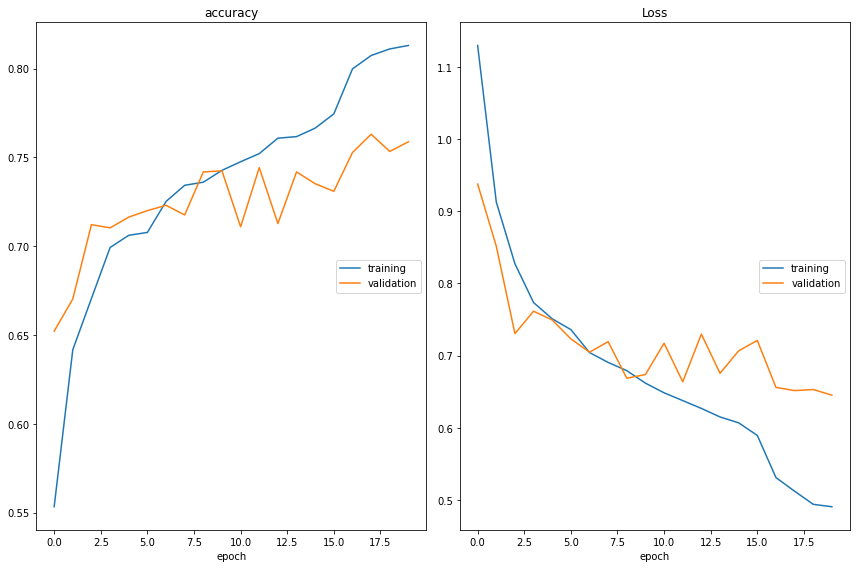

accuracy
	training         	 (min:    0.553, max:    0.813, cur:    0.813)
	validation       	 (min:    0.652, max:    0.763, cur:    0.759)
Loss
	training         	 (min:    0.491, max:    1.130, cur:    0.491)
	validation       	 (min:    0.645, max:    0.938, cur:    0.645)

Epoch 20: val_loss improved from 0.65154 to 0.64525, saving model to FacialExpression_weights.h5
463/463 [==============================] - 137s 294ms/step - loss: 0.4906 - accuracy: 0.8130 - val_loss: 0.6452 - val_accuracy: 0.7588 - lr: 1.2500e-04


In [ ]:
#adam 0.0005 batch=32
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

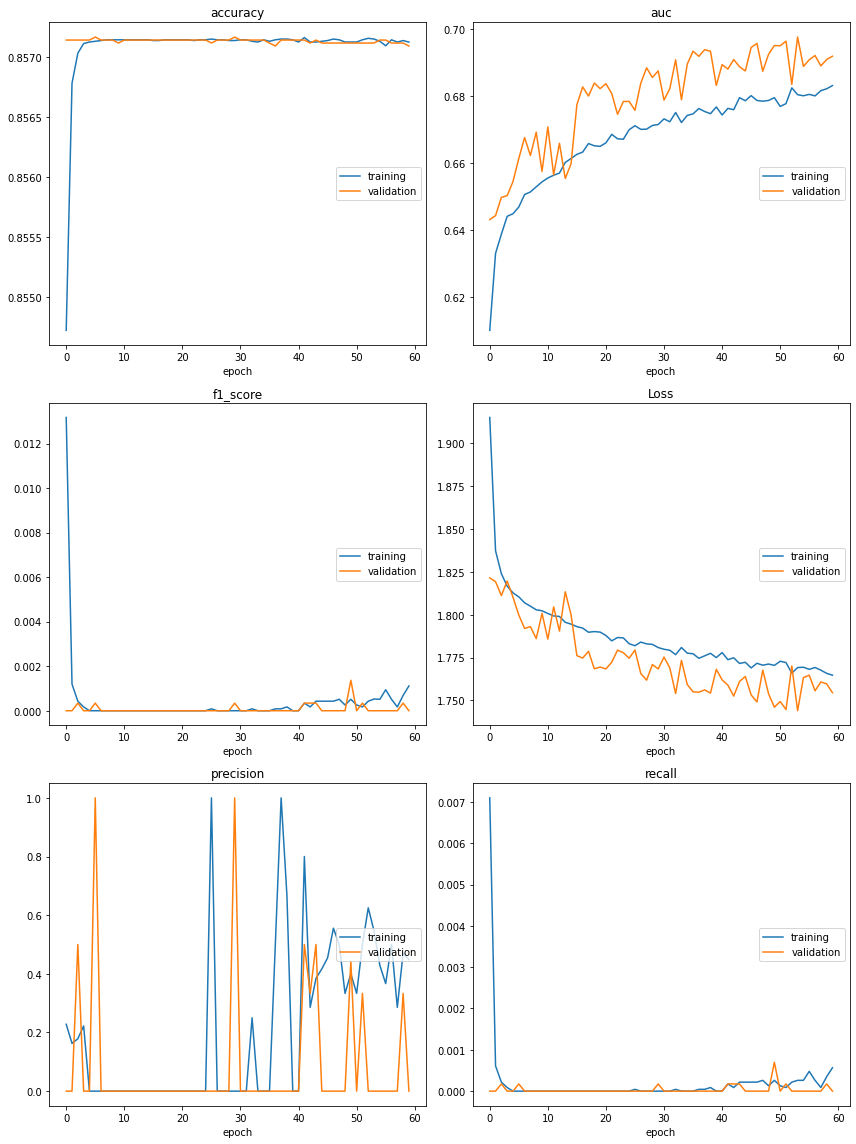

accuracy
	training         	 (min:    0.855, max:    0.857, cur:    0.857)
	validation       	 (min:    0.857, max:    0.857, cur:    0.857)
auc
	training         	 (min:    0.610, max:    0.683, cur:    0.683)
	validation       	 (min:    0.643, max:    0.698, cur:    0.692)
f1_score
	training         	 (min:    0.000, max:    0.013, cur:    0.001)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
Loss
	training         	 (min:    1.765, max:    1.915, cur:    1.765)
	validation       	 (min:    1.744, max:    1.821, cur:    1.755)
precision
	training         	 (min:    0.000, max:    1.000, cur:    0.448)
	validation       	 (min:    0.000, max:    1.000, cur:    0.000)
recall
	training         	 (min:    0.000, max:    0.007, cur:    0.001)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
359/359 [==============================] - 33s 92ms/step - loss: 1.7647 - accuracy: 0.8571 - precision: 0.4483 - recall: 5.6600e-04 - auc: 0.6831 - f1_score: 0.0011

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 60,verbose = 1,callbacks=[pl,lrd,mcp,es])

In [ ]:
model.save("model-final-2.h5")

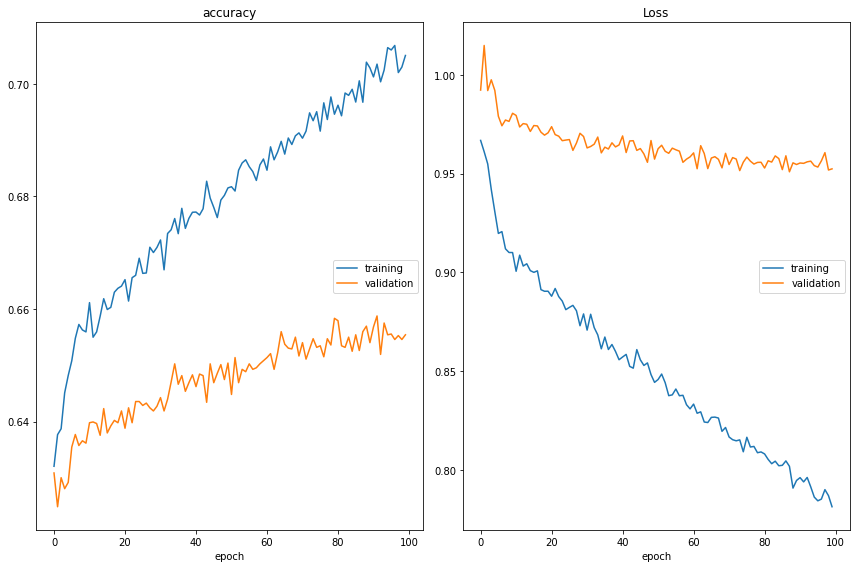

accuracy
	training         	 (min:    0.632, max:    0.707, cur:    0.705)
	validation       	 (min:    0.625, max:    0.659, cur:    0.655)
Loss
	training         	 (min:    0.781, max:    0.967, cur:    0.781)
	validation       	 (min:    0.951, max:    1.015, cur:    0.952)

Epoch 100: saving model to model_weights.h5
448/448 [==============================] - 15s 34ms/step - loss: 0.7813 - accuracy: 0.7050 - val_loss: 0.9524 - val_accuracy: 0.6554 - lr: 1.0000e-05


In [ ]:
epochs = 100
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True,mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.00001,model='auto')
callbacks = [PlotLossesKerasTF(),checkpoint,reduce_lr]

history = model.fit(x=train_generator,steps_per_epoch=steps_per_epoch,epochs=epochs,validation_data=validation_generator,validation_steps=validation_steps, callbacks=callbacks)